Character learning has two components.  First, we need to learn the structure of the automaton representing the character; this remains for future work.

Once we have a structure, we can fit parameters to that structure.  Example parameters include the dynamics of each state and any parameters on guards.  Since we only consider one character at a time, we can abstract the environment into occluding collisions, non-occluding collisions, and hostile collisions.

We'll work with non-hierarchical, non-concurrent hybrid automata for now.  Also, we'll assume left and right movement are mirrored.  Our representation of a state will define, for each variable, whether it has a constant velocity or a constant acceleration (and what that value is); and what transitions are available under what circumstances (a conjunction of abstracted inputs, continuous variable thresholds, timers, any collisions of any type at any normal to the character, and negations of the same).  A state machine is a set of states and an initial state.

In [292]:
# EXECUTE ME!
%matplotlib inline

import pymc3 as pm
import random

import matplotlib.pyplot as plt
import seaborn as sns
#from ipywidgets import interactive, fixed

import numpy as np
import pandas as pd

import theano
import theano.tensor as T

import jumpfinder
from jumpfinder import hold, marioGetX, marioGetY, metroidGetX, metroidGetY
import fceulib

In [2]:
# EXECUTE ME!
RIGHT = 1 << 7
LEFT = 1 << 6
DOWN = 1 << 5
UP = 1 << 4
START = 1 << 3
SELECT = 1 << 2
B = 1 << 1
A = 1 << 0

mario_x = 0x006D
mario_y = 0x00CE

metroid_x = 0x0051
metroid_y = 0x0052

In [ ]:
reload(jumpfinder)

In [315]:
# EXECUTE ME!
jumpButton = A
games = {
    "mario": (
        "mario.nes",
        (hold(0x0, 120) + hold(START | jumpButton, 30) +
         hold(0x0, 150)),
        marioGetX,
        marioGetY
    ),
    "metroid": (
        "metroid.nes",
        (hold(0x0, 60) + hold(START, 1) + hold(0x0, 15) +
         hold(START, 1) + hold(0x0, 600) + hold(LEFT, 400) +
         hold(RIGHT, 30)),
        metroidGetX,
        metroidGetY
    )
}
# CHANGE GAME HERE
(game, startInputs, getx, gety) = games["metroid"]
total = 0
emu = fceulib.runGame(game)
for m in startInputs:
    total = total + 1
    emu.step(m, 0x0)

emu.step(0x0, 0x0)
start = fceulib.VectorBytes()
emu.save(start)
allTrials,minHold,maxHold = jumpfinder.runTrials(emu, start, getx, gety, jumpButton)
(len(allTrials),minHold,maxHold)

(36, 10, 45)

Let's learn three linear-or-constant velocity models.

Move count:35 min hold:10
Record ground->up-control 0 10 prev dy 0.0
10 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0] 1 0 9
11 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1] 1 1 9
12 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2] 1 2 9
13 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3] 1 3 9
14 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4] 1 4 9
15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5] 1 5 9
16 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6] 1 6 9
17 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7] 1 7 9
18 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8] 1 8 9
19 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 1 9 9
Record up-control->up-fixed 10 20 prev dy 0.0
Record up-fixed->down 20 21 prev dy 0.0
Record down->ground 21 44 prev dy 1.0
Move count:37 min hold:10
Record ground->up-control 44 55 prev dy 3.0
Record up-control->up-fixed 55 66 prev dy 0.0
Record up-fixed->down 66 67 prev dy 0.0
Record down->ground 67 91 prev dy 0.0
Move count:39 min hold:10
Record ground->up-cont

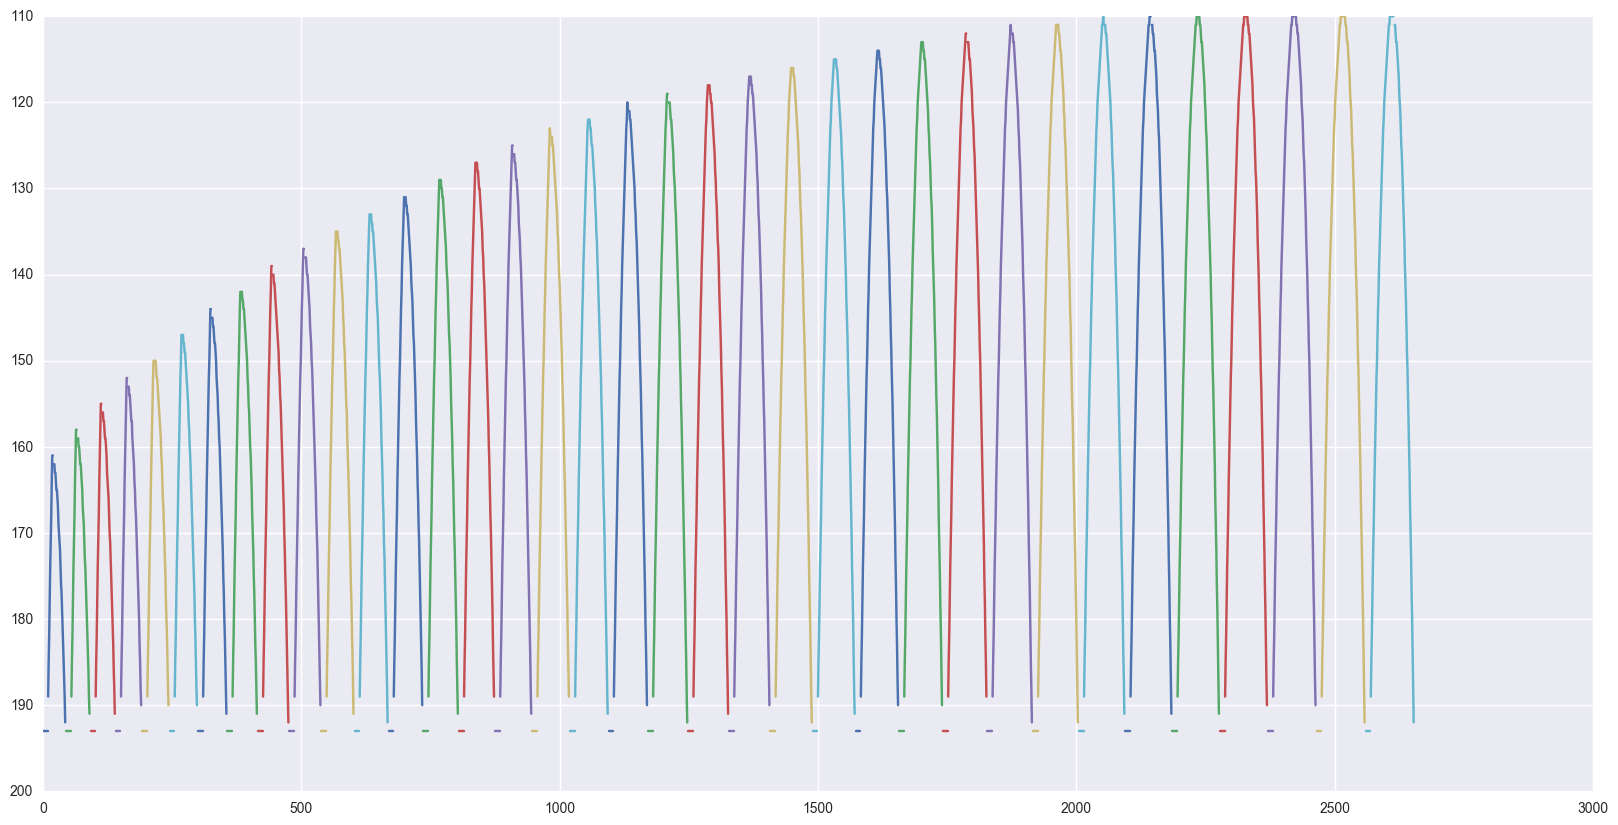

In [325]:
# EXECUTE ME!
mode_names = ["ground", "up-control", "up-fixed", "down"]
switch_conditions = {
    "ground": {
        # starting to rise
        "up-control": lambda moves, movei, stats: stats.y.allVals[movei+1] != stats.y.allVals[0]
    },
    "up-control": {
        # released button or reached max time
        # TODO: replace movei with "time since jump pressed" by scanning back in moves
        "up-fixed": lambda moves, movei, stats: (movei >= minHold and 
                                                 (not (moves[movei] and jumpButton))
                                                ) or movei >= maxHold#,
        # TODO: or hit ceiling
        #"down":lambda moves, movei, stats: stats.y.allVals[movei+1] >= stats.y.allVals[movei]
    },
    "up-fixed": {
        # TODO: or hit ceiling
        "down": lambda moves, movei, stats: stats.y.allVals[movei+1] > stats.y.allVals[movei]
    },
    "down": {
        "ground": lambda moves, movei, stats: stats.y.allVals[movei+1] >= stats.y.allVals[0]
    }
}
modes = dict()
for m in mode_names:
    modes[m] = []

def record_run(modes, state, t, vbls, all_vbls):
    frame = pd.DataFrame(vbls)
    #print str(t)+":"+str(all_vbls)
    prev_vbls = dict(x=all_vbls["x"][t],
                     y=all_vbls["y"][t],
                     dx=all_vbls["dx"][t-1 if t > 0 else 0],
                     dy=all_vbls["dy"][t-1 if t > 0 else 0])
    modes[state].append((t, prev_vbls, frame))

t = 0
state_change_t = 0 # start at 1 just so state_change_t - 1 doesn't wrap
trials = allTrials
all_vbls = dict(x=[],y=[],dx=[],dy=[],t=[])
# Tweak the range and increment to get more precise/slower fitting.
for moves, stats in trials:
    state = "ground"
    vbls = dict(x=[],y=[],dx=[],dy=[],t=[])
    start_t = t
    for i in range(10):
        vbls["x"].append(stats.x.allVals[0])
        all_vbls["x"].append(vbls["x"][-1])
        vbls["y"].append(stats.y.allVals[0])
        all_vbls["y"].append(vbls["y"][-1])
        vbls["dx"].append(0.)
        all_vbls["dx"].append(vbls["dx"][-1])
        vbls["dy"].append(0.)
        all_vbls["dy"].append(vbls["dy"][-1])
        vbls["t"].append(t-state_change_t)
        all_vbls["t"].append(vbls["t"][-1])
        t += 1
    print "Move count:"+str(len(moves))+" min hold:"+str(minHold)
    for i, m in enumerate(moves):
        transitions = switch_conditions[state]
        for target, condition in transitions.items():
            if condition(moves, i, stats):
                print "Record "+state+"->"+target,state_change_t,t,"prev dy",str(all_vbls["dy"][state_change_t-1])
                record_run(modes, state, state_change_t, vbls, all_vbls)
                state_change_t = t
                vbls["x"] = []
                vbls["y"] = []
                vbls["dx"] = []
                vbls["dy"] = []
                vbls["t"] = []
                state = target
                break
        vbls["x"].append(stats.x.allVals[i+1])
        all_vbls["x"].append(vbls["x"][-1])
        vbls["y"].append(stats.y.allVals[i+1])
        all_vbls["y"].append(vbls["y"][-1])
        vbls["dx"].append(stats.x.allVals[i+1] - stats.x.allVals[i])
        all_vbls["dx"].append(vbls["dx"][-1])
        vbls["dy"].append(stats.y.allVals[i+1] - stats.y.allVals[i])
        all_vbls["dy"].append(vbls["dy"][-1])
        vbls["t"].append(t-state_change_t)
        all_vbls["t"].append(vbls["t"][-1])
        if t < 20:
            print t,all_vbls["t"],(m&jumpButton),i,(minHold-1)
        t += 1
        if state == "ground" and i > 5:
            break
    # Force to ground state. Collections will be reset at the front of the next loop.
    if state != "ground":
        record_run(modes, 
                   state,
                   state_change_t,
                   vbls,
                   all_vbls)
        state_change_t = t
    

plt.figure(figsize=(20,10))

for m in modes:
    #print m
    for (run_start, prev_vbls, run_vbls) in modes[m]:
        #print str(run_start)+".."+str(run_start+len(run_vbls["y"]))
        #print "PVs:"+str(prev_vbls)
        plt.plot(run_vbls["t"]+run_start, run_vbls["y"])


plt.gca().invert_yaxis()
plt.show()


In [303]:
# Original approach with resetp
# MAYBE EXECUTE ME! Then the second-to-last cell.
with pm.Model() as modelReset:
    accs = dict()
    resets = dict()
    resetps = dict()
    resetvals = dict()
    sigs = dict()
    run_params = dict()
    for m in modes:
        accs[m] = dict()
        resets[m] = dict()
        resetps[m] = dict()
        resetvals[m] = dict()
        sigs[m] = dict()
        # This is totally just from modifying existing linear regression code for pymc3
        # I'm using one acc per mode and one initial DY per mode, but really the DY should
        #  be per transition INTO the mode, i.e. mode->mode pair/transition ID.
        # One initial DY per trial grew my model too quickly, so I think it's fine to interpret
        #  noisy or uncertain DY0 values as "no discrete velocity update".

        # Maybe learn a "Is there a reset?" binary variable and a "Reset constant" real variable, and the velocity is dy0*(1-reset?) + reset? * resetdy + acc * t

        #Later: "dx","dy"
        for v in ["dy"]:
            # TODO: try shape=() on the vars rather than arrays of individual vars?
            accs[m][v] = pm.Normal(m+"_"+v+"_acc", 0, sd=20)
            resetps[m][v] = pm.Beta(m+"_"+v+"_resetp",alpha=1,beta=1)
            resets[m][v] = pm.Bernoulli(m+"_"+v+"_reset",p=resetps[m][v])
            resetvals[m][v] = pm.Normal(m+"_"+v+"_resetval",0,sd=20)
            # I'm not sure whether it's OK to learn one sigma per mode or one per trial.
            #  When I learned one per mode, I encountered an error about nonsense values...
            #  But that may have been unrelated?
            sigs[m][v] = pm.HalfCauchy(m+"_"+v+"_sigma",beta=10,testval=1.)
        
        run_params[m] = []
        # TODO: try shape=() on the vars rather than arrays of individual vars?
        for (start, prev_vbls, vbls) in modes[m]:
            #print "Into "+m+" prev "+str(prev_vbls["dy"])
            #Investigate whether I should do something special to handle the quantized values?
            params = dict()
            # TODO: try shape=() on the vars rather than arrays of individual vars?
            #Later: "dx","dy"
            for v in ["dy"]:
                # TODO: this could be lifted into a single "prev_vel" variable for all the trials I think, maybe with a different (multinomial?) distribution.
                prev_vel = pm.Normal(m+"_"+v+"_"+str(start)+"_prev",mu=prev_vbls[v],sd=1., observed=[prev_vbls[v]])
                continue_term = (1-resets[m][v])*prev_vel
                reset_term = resets[m][v]*resetvals[m][v]
                flow_term = accs[m][v]*(vbls["t"]+1)
                lik = pm.Normal(m+"_"+v+"_"+str(start),
                                mu=continue_term+reset_term+flow_term,
                                sd=sigs[m][v],
                                observed=vbls[v])
                params[v] = (prev_vel,lik)
            run_params[m].append((start,prev_vbls,vbls,params))
    print "Find start"
    start = dict()
    # MAP supposedly doesn't always give good estimates, plus it takes a long time.
    # The sample code used it plus NUTS, but I think metropolis without any hints does fine.
    #start = pm.find_MAP()
    print str(start)
    print "Set up step method"
    step = pm.Metropolis()
    #step = pm.NUTS(scaling=start)
    print "Start sampling"
    traceReset = pm.sample(6000, step, progressbar=True)
    print "Done!"

Applied logodds-transform to fall_dy_resetp and added transformed fall_dy_resetp_logodds_ to model.
Applied log-transform to fall_dy_sigma and added transformed fall_dy_sigma_log_ to model.
Applied logodds-transform to rise_dy_resetp and added transformed rise_dy_resetp_logodds_ to model.
Applied log-transform to rise_dy_sigma and added transformed rise_dy_sigma_log_ to model.
Applied logodds-transform to ground_dy_resetp and added transformed ground_dy_resetp_logodds_ to model.
Applied log-transform to ground_dy_sigma and added transformed ground_dy_sigma_log_ to model.


Find start
{}
Set up step method


INFO (theano.gof.compilelock): Refreshing lock /Users/jcosborn/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-2.7.12-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/jcosborn/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-2.7.12-64/lock_dir/lock
  0%|          | 1/6000 [00:00<10:59,  9.09it/s]

Start sampling


100%|██████████| 6000/6000 [00:11<00:00, 525.66it/s]

Done!


In [ ]:
# # DON'T USE ME!
# # This is the version with matrix-ization, it takes medium time to compile and forever to sample
# with pm.Model() as modelMatrix:
#     var_order = ["dx","dy"]
#     accs = dict()
#     consts = dict()
#     sigs = dict()
#     prev_weights = dict()
#     for m in modes:
#         # TODO: change back to per-ha-variable vars, they sampled much much faster for some reason.
#         sigs[m] = pm.HalfCauchy(m+"_sigma",beta=10,testval=1.,shape=2)
#         accs[m] = pm.Normal(m+"_acc",mu=0,sd=20,testval=0.,shape=(2,1))
#         consts[m] = pm.Normal(m+"_const",mu=0.,sd=20,shape=2)
#         prev_weights[m] = pm.Normal(m+"_weights",mu=1.,shape=(2,2))
        
#         # TODO: pack all trials at once into variable shapes
#         for (start, prev_vbls, vbls) in modes[m]:
#             #Investigate whether I should do something special to handle the quantized values?
#             # this should be 2x1 broadcasted out
#             prev_vels = pm.Normal(m+"_"+str(start)+"_prev",
#                                   shape=2,
#                                   mu=[prev_vbls["dx"],prev_vbls["dy"]],
#                                   observed=[[prev_vbls["dx"],prev_vbls["dy"]]])
#             times = np.array(vbls["t"])[:,None]
#             vals = np.array([vbls["dx"],vbls["dy"]])
#             weights = prev_weights[m]
#             muPrev = weights.dot(prev_vels.T)
#             #TODO: this expression should also have a Theano.clip() with a learnable parameter for each variable min/max.
#             muInit = (consts[m] + muPrev.T)
#             mu = muInit.T + accs[m].dot(times.T)
#             # Lots of transpose dancing here, I'm not totally sure it's right... is it slowing things down?
#             lik = pm.Normal(m+"_"+str(start),
#                             mu=mu.T,
#                             sd=sigs[m],
#                             shape=(2,20),
#                             observed=vals.T)
#     print "Find start"
#     start = dict()
#     #start = pm.approx_hessian(model.test_point)
#     print str(start)
#     print "Set up step method"
#     step = pm.Metropolis()
#     #step = pm.NUTS(scaling=start)
#     print "Start sampling"
#     traceMatrix = pm.sample(10000, step, progressbar=True)
#     print "Done!"

In [339]:
# This is the version without matrix-ization, it takes about as long to compile (unmeasured) and samples over 10x faster even single-threaded
# MAYBE EXECUTE ME! Then the last cell.
with pm.Model() as modelLinearAndClip:
    accs = dict()
    sigs = dict()
    prev_weights = dict()
    initcliplo = dict()
    initcliphi = dict()
    for m in modes:
        if len(modes[m]) == 0:
            continue
        sigs[m] = dict()
        accs[m] = dict()
        prev_weights[m] = dict()
        initcliplo[m] = dict()
        initcliphi[m] = dict()
        for v in ["dx","dy"]:
            sigs[m][v] = pm.HalfCauchy(m+"_"+v+"_sigma",beta=10.,testval=1.)
            accs[m][v] = pm.Normal(m+"_"+v+"_acc",mu=0,sd=10.,testval=0.)
            allVals = []
            allTs = []
            allPrevs = []
            for _s,prevs,vbls in modes[m]:
                allVals = allVals + list(vbls[v])
                allTs = allTs + list(vbls["t"])
                # TODO: use vars uniformly distributed between prevs[v] and prevs[v]+1 to account for uncertainty?
                #  Not sure how to get a nice Theano-friendly setup for that though
                allPrevs = allPrevs + [[prevs["dx"],
                                        prevs["dy"],
                                        1.0] for i in range(len(vbls[v]))]
            init_weights = [1.0 if vi == v else 0.0 for vi in ["dx","dy","$const"]]
            prev_weights[m][v] = pm.Normal(m+"_"+v+"_weights",
                                           mu=init_weights,
                                           testval=init_weights,
                                           sd=10.,
                                           shape=3)
            vals = np.array(allVals)
            # gotta add 1 to every t since by the time we read the values it's been in the state for one timestep already.
            ts = np.array(allTs)+1 
            prevs = np.array(allPrevs)
            muInit = prev_weights[m][v].dot(prevs.T)
            mu = muInit + accs[m][v]*ts
            lik = pm.Normal(m+"_"+v, 
                            mu=mu, 
                            sd=sigs[m][v], 
                            observed=vals)
    print "Find start"
    start = dict()
    #start = pm.approx_hessian(model.test_point)
    print str(start)
    print "Set up step method"
    step = pm.Metropolis()
    #step = pm.NUTS(scaling=start)
    print "Start sampling"
    traceLinearAndClip = pm.sample(10000, step, progressbar=True)
    print "Done!"

Applied log-transform to down_dx_sigma and added transformed down_dx_sigma_log_ to model.
Applied log-transform to down_dy_sigma and added transformed down_dy_sigma_log_ to model.
Applied log-transform to up-control_dx_sigma and added transformed up-control_dx_sigma_log_ to model.
Applied log-transform to up-control_dy_sigma and added transformed up-control_dy_sigma_log_ to model.
Applied log-transform to up-fixed_dx_sigma and added transformed up-fixed_dx_sigma_log_ to model.
Applied log-transform to up-fixed_dy_sigma and added transformed up-fixed_dy_sigma_log_ to model.
Applied log-transform to ground_dx_sigma and added transformed ground_dx_sigma_log_ to model.
Applied log-transform to ground_dy_sigma and added transformed ground_dy_sigma_log_ to model.


Find start
{}
Set up step method


  1%|          | 63/10000 [00:00<00:50, 198.28it/s]

Start sampling


100%|██████████| 10000/10000 [00:22<00:00, 442.74it/s]

Done!


In [160]:
with modelLinearAndClip:
    traceLinearAndClip = pm.sample(80000, step, progressbar=True)

100%|██████████| 80000/80000 [00:33<00:00, 2368.26it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x139e08350>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x172cba610>]], dtype=object)

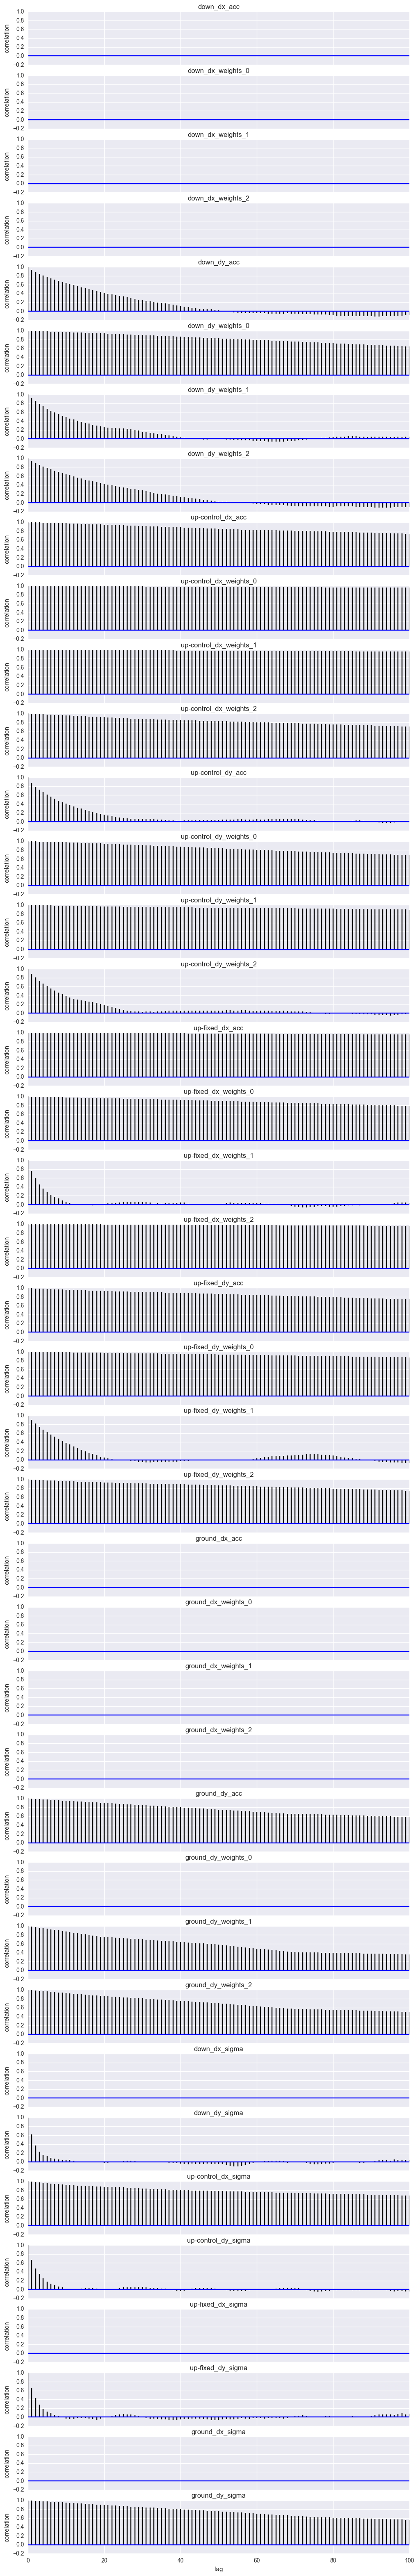

In [332]:
pm.autocorrplot(traceLinearAndClip[len(traceLinearAndClip)*0.75:])

In [333]:
pm.stats.summary(traceLinearAndClip[len(traceLinearAndClip)*0.75:-1:10])


down_dx_acc:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.000            0.000            0.000            [0.000, 0.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.000          0.000          0.000          0.000


down_dx_weights:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.000            0.000            0.000            [1.000, 1.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.000          1.000 

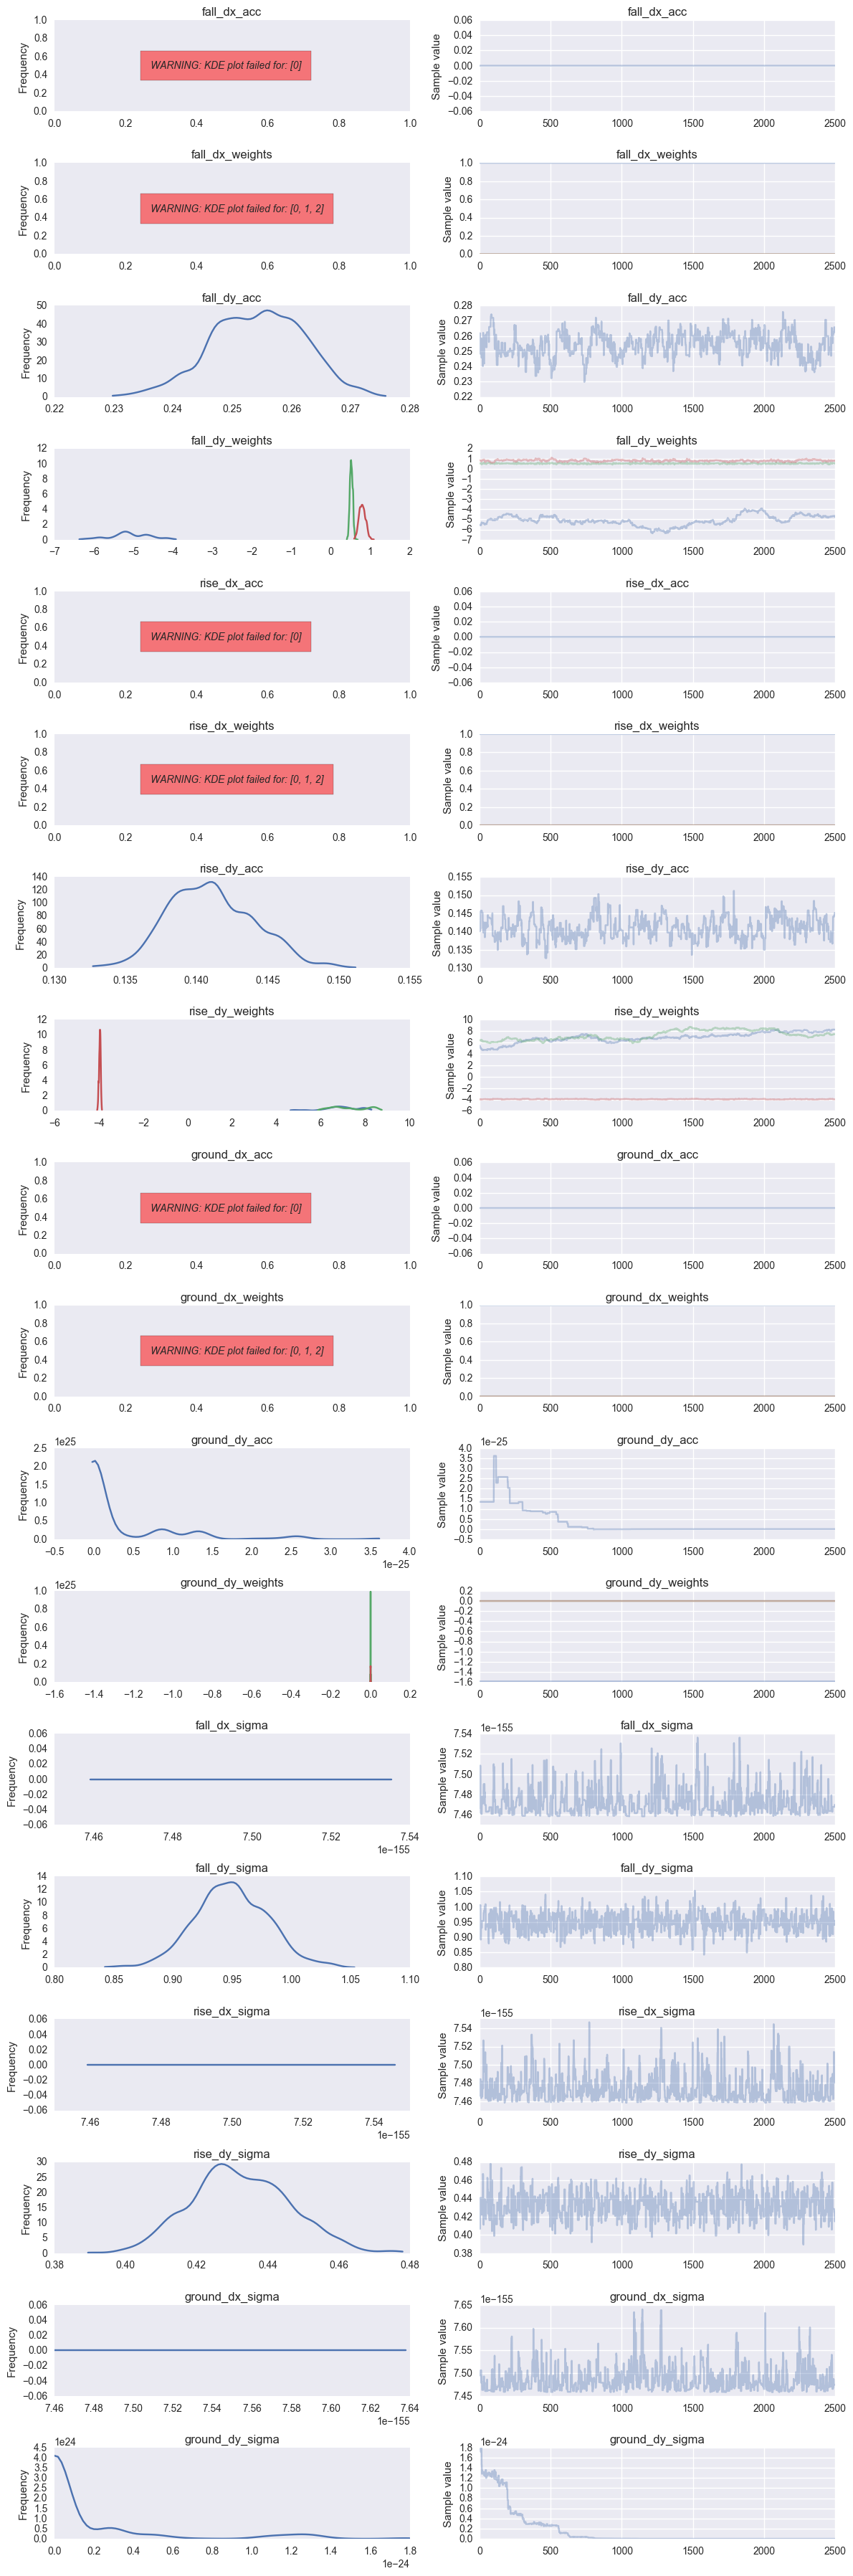

In [280]:
plt.figure(figsize=(6, 6))
pm.traceplot(traceLinearAndClip[len(traceLinearAndClip)*0.75:-1])
plt.tight_layout();

In [119]:
ppc = pm.sample_ppc(traceLinearAndClip, samples=500, model=modelLinearAndClip, size=100)

In [133]:
ppc["rise_dy"].mean()

-2.7790133371564689

In [193]:
# Visualize the initial approach with resets
# EXECUTE ME right after the first model (the one with resets)
from jumpfinder import marioModel,DT
import copy
samples = 200
m = copy.deepcopy(marioModel)

realYs = []
for (_moves,stats) in trials:
    realYs = realYs + stats.y.allVals
plt.figure(figsize=(20,10))

sample = 0
for rand_trace in np.random.randint(1000, len(traceReset), samples):
    sample += 1
    t = traceReset[rand_trace]
    m.params["gravity"].update(t["fall_dy_acc"]/(DT*DT),True)
    m.params["risingGravity"].update(t["rise_dy_acc"]/(DT*DT),True)
    m.params["minButtonDuration"].update(minHold*DT,True)
    m.params["maxButtonDuration"].update(maxHold*DT,True)
    if t["rise_dy_reset"] != 0:
        m.params["jumpStartSpeed"].update(t["rise_dy_resetval"]/DT,True)
    else:
        m.params["jumpStartSpeed"].update(0,True)
    if t["fall_dy_reset"] != 0:
        m.params["jumpToFallStartSpeed"].update(t["fall_dy_resetval"]/DT,True)
    else:
        m.params["jumpToFallStartSpeed"].update(0,True)
    modelYs = []
    for (moves,stats) in trials:
        val = m.makeValuation({("x", 0): stats.x.allVals[0], ("y", 0): stats.y.allVals[0]})
        modelYs.append(val.variables[("y",0)])
        for mi,move in enumerate(moves):
            m.step(val, 
                   DT, 
                   set(["jump"] if move & jumpButton else []), 
                   set([("bottom", "ground")] if val.variables[("y", 0)] > stats.y.allVals[0]-1 and mi >= 5 else []))
            modelYs.append(val.variables[("y",0)])
    plt.plot(modelYs,"x-")
plt.plot(realYs,"o")
plt.gca().invert_yaxis()
plt.show()

NameError: name 'traceReset' is not defined

In [ ]:
traceLinearAndClip[5000]

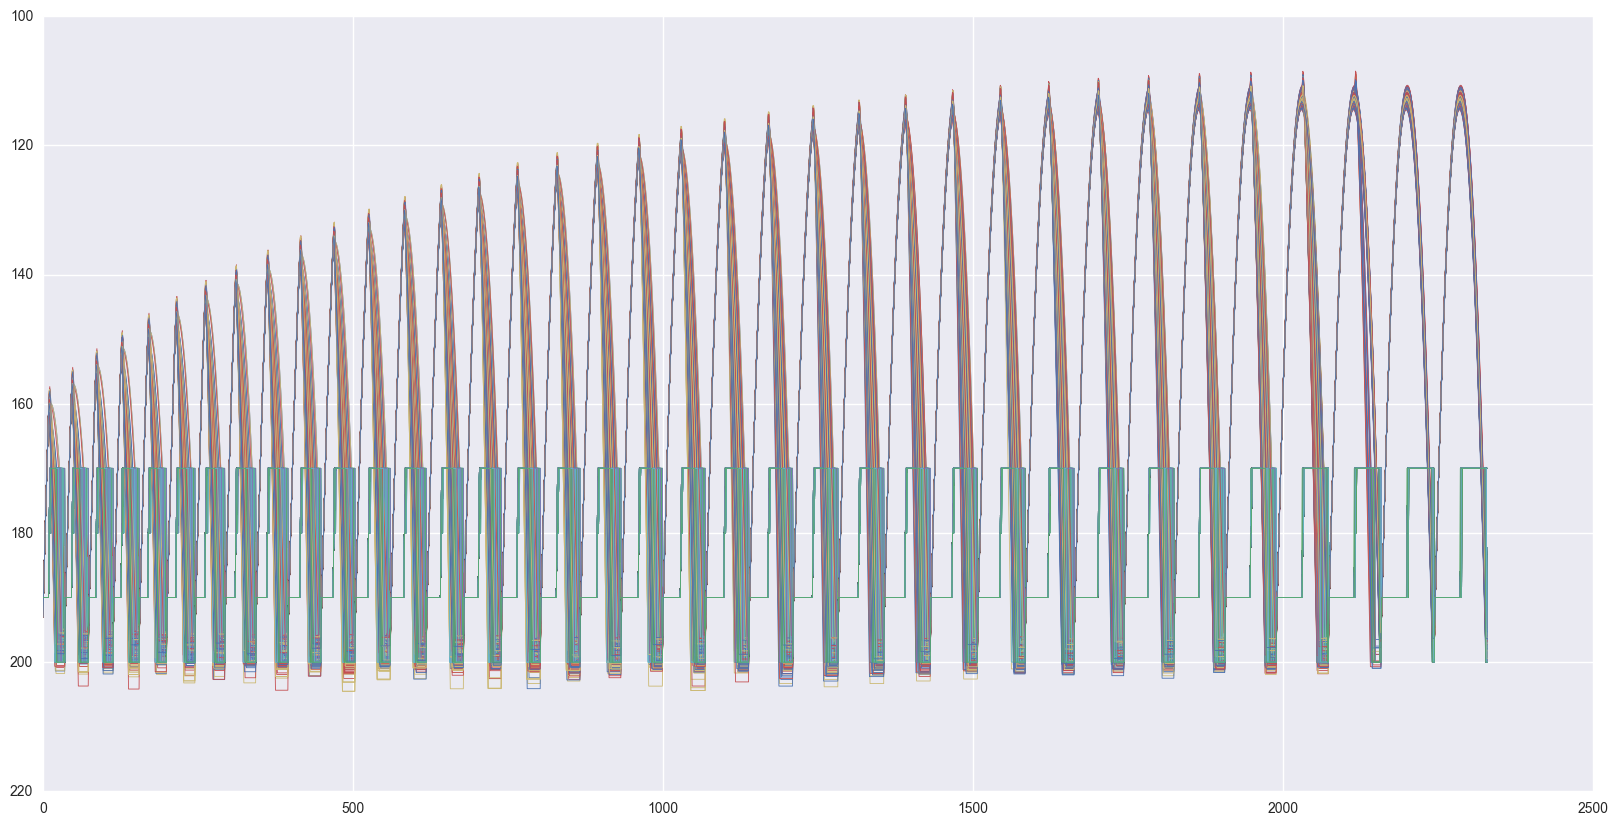

In [342]:
# Visualize the new approach with a weight vector and clipping.
# EXECUTE ME after setting up the third model (no resets, no matrix-ization)
reload(jumpfinder)
from jumpfinder import marioModel,DT
#
import copy
samples = 100
m = copy.deepcopy(marioModel)

realYs = []
for (_moves,stats) in trials:
    realYs = realYs + stats.y.allVals
plt.figure(figsize=(20,10))
sample = 0
for rand_trace in np.random.randint(len(traceLinearAndClip)*0.75, len(traceLinearAndClip), samples):
    sample += 1
    t = traceLinearAndClip[rand_trace]
    m.params["gravity"].update(t["down_dy_acc"]/(DT*DT),True)
    m.params["up-control-gravity"].update(t["up-control_dy_acc"]/(DT*DT),True)
    m.params["up-fixed-gravity"].update(t["up-fixed_dy_acc"]/(DT*DT),True)
#     if t["up-fixed_dy_acc"] < 0 or t["up-control_dy_acc"] < 0 or t["down_dy_acc"] > 0:
#         # Outlier, ignore
#         continue
    m.params["minButtonDuration"].update(minHold*DT,True)
    m.params["maxButtonDuration"].update(maxHold*DT,True)
    
    m.params["groundToUpControlDYReset"] = (
        "+", 
        t["up-control_dy_weights"][2]/DT,
        ("+", 
         ("*", t["up-control_dy_weights"][0], ("x", 1)),
         ("*", t["up-control_dy_weights"][1], ("y", 1)))
    )
    m.params["upControlToUpFixedDYReset"] = (
        "+", 
        t["up-fixed_dy_weights"][2]/DT,
        ("+", 
         ("*", t["up-fixed_dy_weights"][0], ("x", 1)),
         ("*", t["up-fixed_dy_weights"][1], ("y", 1)))
    )

    # Unused learned weights: ground, down.
    

    # then do jump trials with horizontal speed and make sure we learn the right weights.
    # then try to learn the clipping for earlyOutClipVel and other discrete velocity updates
    modelYs = []
    modelModes = []
    mode_nums = {"ground": 200, "up-control": 190, "up-fixed": 180, "down": 170}
    for trial, (moves,stats) in enumerate(trials):
        val = m.makeValuation({("x", 0): stats.x.allVals[0], ("y", 0): stats.y.allVals[0]})
        for mi,move in enumerate(moves):
            m.step(val, 
                   DT, 
                   set(["jump"] if move & jumpButton else []), 
                   set([("bottom", "ground")] if val.variables[("y", 0)] > stats.y.allVals[0]-1 and mi >= 5 else []))
            modelModes.append(mode_nums[val.state])
            modelYs.append(val.variables[("y",0)])
        modelYs.append(modelYs[-1])
        modelModes.append(mode_nums[val.state])
    plt.plot(modelYs,"x-",lw=0.6)
    plt.plot(modelModes,"+-",lw=0.6)
#plt.plot(realYs,"o")
plt.gca().invert_yaxis()
plt.show()